Question 1
==

$$x_{t+1}=A_0x_t+Cw_{t+1}$$
$$y_{t+1}=Gx_t+Dw_{t+1}$$
with $x_t \in \mathbb{R}^n$, $y_t \in \mathbb{R}^m$ and $w_t \in \mathbb{R}^k$.

1.5.
--

This code borrows from QuantEcon's http://lectures.quantecon.org/jl/linear_models.html and http://lectures.quantecon.org/jl/kalman.html, but I have to adapt the functions due to the generalized setup here.

In [1]:
using Distributions 

type LSSgeneralized
    #matrices
    A::Matrix
    C::Matrix
    G::Matrix
    D::Matrix
    
    #dimensions
    k::Int
    n::Int
    m::Int
    
    #prior
    mu_0::Vector
    Sigma_0::Matrix
    dist::MultivariateNormal
    
    #filter
    x_hat_μ::Vector
    x_hat_Σ::Matrix
end

function LSSgeneralized(A::Matrix, C::Matrix, G::Matrix, D::Matrix, 
        mu_0::Array, Sigma_0::Matrix)
    m = size(G, 1)
    n = size(G, 2)
    k = size(C, 2)
    
    return LSSgeneralized(A,C,G,D,k,n,m,mu_0,Sigma_0,MultivariateNormal(mu_0, Sigma_0),
        mu_0, Sigma_0)
end

LSSgeneralized

Mind: $(x_t,y_{t+1})$.

In [2]:
function simulate(lss::LSSgeneralized, ts_length=100;x_init=rand(lss.dist))
    x = Array(Float64, lss.n, ts_length)
    y = Array(Float64, lss.m, ts_length)
    x[:, 1] = x_init
    
    w = randn(lss.k, ts_length - 1)
    for t=1:ts_length-1
        y[:, t] = lss.G * x[:,t] .+ lss.D * w[:, t]
        x[:, t+1] = lss.A * x[:, t] .+ lss.C * w[:, t]
    end
    
    y[:,end] = NaN*zeros(lss.m)    #last observation is not defined!

    return (x', y')
end

simulate (generic function with 2 methods)

Mind that $\hat{x}_t$ is a nowcast! The function "prior_to_nowcast" takes a single $y_t$ observation and does the update.

In [3]:
function prior_to_nowcast!(k::LSSgeneralized, y::Vector)

    K = (k.A*k.x_hat_Σ*k.G' + k.C*k.D')*inv(k.G*k.x_hat_Σ*k.G'+k.D*k.D')
    
    k.x_hat_μ = k.A*k.x_hat_μ+K*(y-k.G*k.x_hat_μ)
    k.x_hat_Σ = (k.A-K*k.G)*k.x_hat_Σ*(k.A-K*k.G)' + (k.C-K*k.D)*(k.C-K*k.D)'
    
    Void
end

prior_to_nowcast! (generic function with 1 method)

The function "kalmanian" takes a whole time series, with one observation per row.

In [4]:
function kalmanian(k::LSSgeneralized, y::Matrix)
    
    T=size(y,1)
    Xhat = Array(MultivariateNormal,T)

    k.x_hat_μ = k.dist.μ  #reset
    k.x_hat_Σ = full(k.dist.Σ)  #reset
    
    for i in 1:size(y,1)
        prior_to_nowcast!(k,y[i,:])
        Xhat[i] = MultivariateNormal(k.x_hat_μ, k.x_hat_Σ)
    end
    
    return Xhat
end

kalmanian (generic function with 1 method)

In [5]:
function state_likelihood(k::LSSgeneralized, x::Matrix)
    T = size(x,1)
    return sum([log(pdf(MultivariateNormal(k.A*x[t-1,:],k.C*k.C'), x[t,:])) for t in 2:T]) +
                log(pdf(k.dist,x[1,:]))
end

state_likelihood (generic function with 1 method)

In [6]:
function observation_likelihood(k::LSSgeneralized, y::Matrix)
    T = size(y,1)
    
    Xhat = kalmanian(k,y)
    return sum([
        log(pdf(MultivariateNormal(k.G*Xhat[t-1].μ,k.G*full(Xhat[t-1].Σ)*k.G' + 
            k.D*k.D'), y[t,:])) 
        for t in 2:T-1])
end

observation_likelihood (generic function with 1 method)

1.6
--

In [7]:
ρ=0.8; σ1=0.02; σ2=0.05; σ3=0.03;

In [8]:
lss = LSSgeneralized([ρ 0; 0 0 ], [σ1 0 0; 0 σ2 0], [1 1], 
                     [0 0 σ3], [0, 0], [0.01 0; 0 0.01]);

In [9]:
data = simulate(lss,160);

In [10]:
Xhat = kalmanian(lss,data[2]);

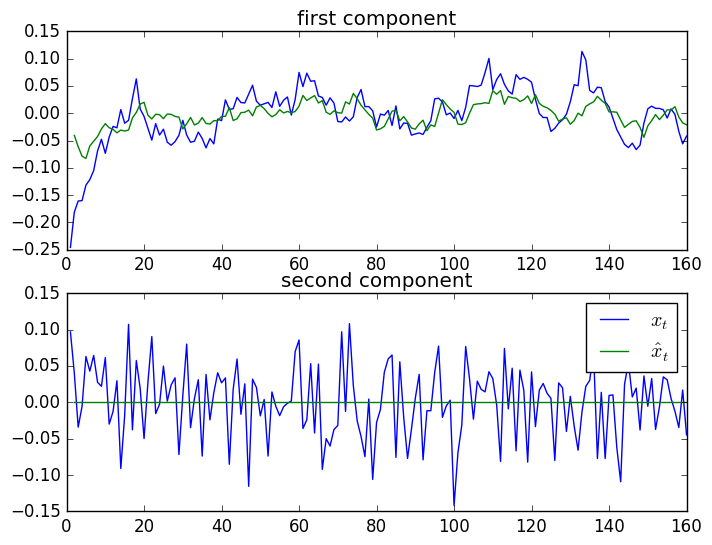

PyObject <matplotlib.legend.Legend object at 0x31c871c18>

In [11]:
using PyPlot
subplot(211)
plot(1:160,data[1][:,1], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[1] for t in 1:160], label=L"$\hat{x}_t$")
title("first component")
subplot(212)
plot(1:160,data[1][:,2], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[2] for t in 1:160], label=L"$\hat{x}_t$")
title("second component");
legend(loc="upper right")

Nothing can be inferred about the transitory component, since there is not autocorrelation between $x_t^1$ and $x_t^2$.

1.7
--

In [12]:
ρ_grid = collect(linspace(0,1,101));

  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Max/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/Max/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Max/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/Max/.julia/v0.5

Given the sample of $x_t$ drawn above the likelihood maximizing $\rho$ is:

In [13]:
ρ_grid[indmax([state_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[1])
        for ρstar in ρ_grid])]

0.84

Given the sample of $y_t$ drawn above the likelihood maximizing $\rho$ is:

In [14]:
ρ_grid[indmax([observation_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[2])
        for ρstar in ρ_grid])]

0.84

Quite good fit!

Question 2
==
2.19
--

In [15]:
iq = LSSgeneralized(reshape([1],1,1),reshape([0],1,1), reshape([1],1,1), 
        reshape([10],1,1), [100], reshape([10.],1,1));

In [16]:
data = simulate(iq,51,x_init=100.);

In [17]:
Xhat = kalmanian(iq,data[2]);

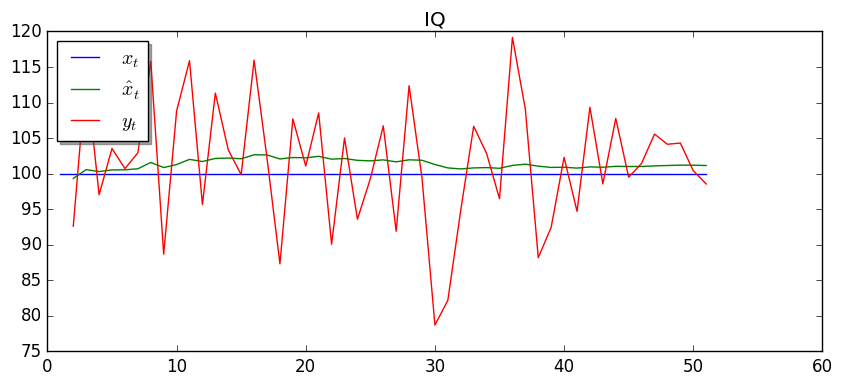

In [18]:
figure(figsize=[10,4])
plot(1:size(data[1],1),data[1][:,1], label=L"$x_t$")
plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], label=L"$\hat{x}_t$")
plot((1:size(data[1],1))+1,data[2][:,1], label=L"$y_t$")
title("IQ");
legend(loc="upper right", shadow=true);

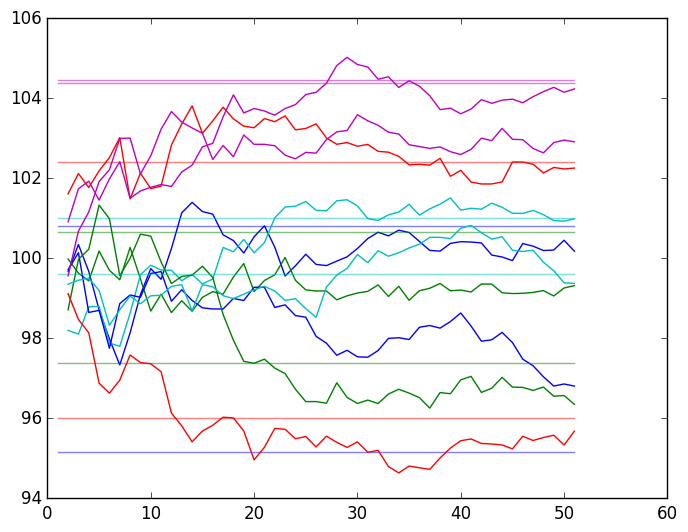

In [19]:
cols = ["b", "g", "r", "c", "m", "b", "g", "r", "c", "m"]

for i in 1:10
    data = simulate(iq,51)
    Xhat = kalmanian(iq,data[2]);
    plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:length(data[1]),data[1], color=cols[i], alpha=0.5)
end

2.26
--
I guess I have to change all the functions, yet again!

In [20]:
even(n) = n == 0 ? true  :  odd(n-1)
odd(n)  = n == 0 ? false : even(n-1)

function simulateG(lss::LSSgeneralized, Godd::Matrix, Geven::Matrix, 
                   ts_length=100;x_init=rand(lss.dist))
    x = Array(Float64, lss.n, ts_length)
    y = Array(Float64, lss.m, ts_length)
    x[:, 1] = x_init
    
    w = randn(lss.k, ts_length - 1)
    for t=1:ts_length-1 #t=1 is x_0, y_1
        if even(t) 
            y[:, t] = Geven * x[:,t] .+ lss.D * w[:, t]
        else
            y[:, t] = Godd * x[:,t] .+ lss.D * w[:, t]
        end
        x[:, t+1] = lss.A * x[:, t] .+ lss.C * w[:, t]
    end
    
    y[:,end] = NaN*zeros(lss.m)    #last observation is not defined!

    return (x', y')
end

function kalmanian(k::LSSgeneralized, y::Matrix, Godd::Matrix, Geven::Matrix)
    
    T=size(y,1)
    Xhat = Array(MultivariateNormal,T)

    k.x_hat_μ = k.dist.μ  #reset
    k.x_hat_Σ = full(k.dist.Σ)  #reset
    
    for t in 1:size(y,1)
        if even(t) 
            k.G = Geven
        else 
            k.G = Godd
        end
        prior_to_nowcast!(k,y[t,:])
        k.x_hat_Σ[2,1] = k.x_hat_Σ[1,2]
        Xhat[t] = MultivariateNormal(k.x_hat_μ, k.x_hat_Σ)
    end
    
    return Xhat
end

kalmanian (generic function with 2 methods)

In [21]:
Geven = [0.9 0.1]
Godd = [0.01 0.99]
iq2 = LSSgeneralized([1 0; 0 1], [0 0; 0 0], [0.9 0.1], [sqrt(50) 0],
            [100, 100], [10. 0; 0 10.]);

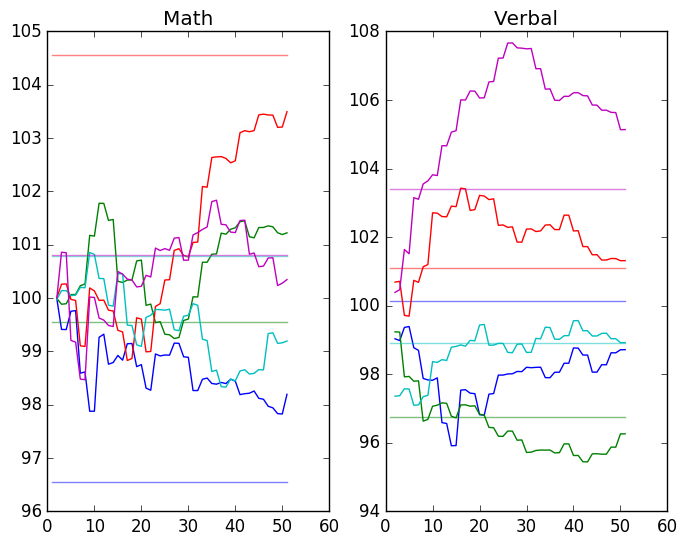

In [29]:
cols = ["b", "g", "r", "c", "m"]

for i in 1:5
    data = simulateG(iq2, Godd, Geven, 51)
    Xhat = kalmanian(iq2, data[2], Godd, Geven)
    subplot(121)
    plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:size(data[1],1),data[1][:,1], color=cols[i], alpha=0.5)
    title("Math")
    subplot(122)
    plot((1:size(data[1],1))+1,[Xhat[t].μ[2] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:size(data[1],1),data[1][:,2], color=cols[i], alpha=0.5)
    title("Verbal")
end

In [33]:
data = simulateG(iq2, Godd, Geven, 1000)
Xhat = kalmanian(iq2, data[2], Godd, Geven);

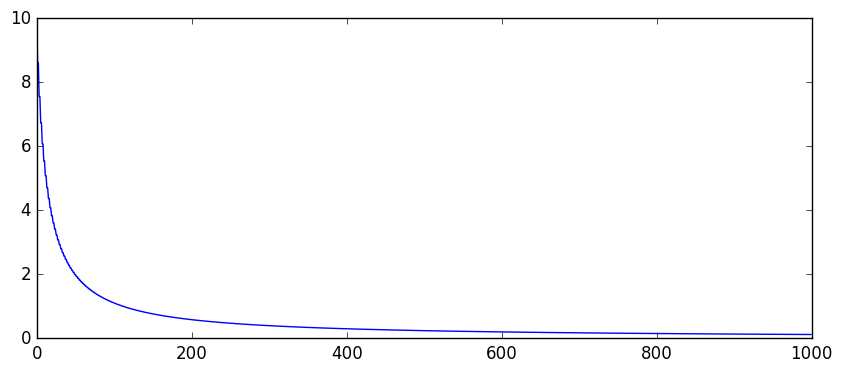

In [42]:
figure(figsize=[10, 4])
plot([maximum(abs(full(Xhat[t].Σ)[:])) for t in 1:1000]);

The $\Sigma_t$ matrix converges nicely!

Question 3
==
3.1
--
From a theory standpoint policy function iteration needs a good initial guess, whereas value function iteration (Banach's fixed point theorem) works for every starting value.
Practically, policy function iterations need far less runtime.
3.2
--
I am going to use the QuantEcon functions on LQ control: http://lectures.quantecon.org/jl/lqcontrol.html. The function "stationary_values" solves the Riccati equation for $P_t$.

Question 4
==
4.3
--
I use the QuantEcon functions on LQ control: http://lectures.quantecon.org/jl/lqcontrol.html.


In [23]:
r=0.05; β=1/(1+r); c_bar=1.5; μ=2; σ=0.15; T=50; q=1e4;
m1=T*μ/(T/2)^2; m2=-μ/(T/2)^2;
A=[1+r -c_bar m1 m2; 0 1 0 0; 0 1 1 0; 0 1 2 1]
B=[-1; 0; 0; 0]
C=[σ; 0; 0; 0]
R=zeros(4,4)
R_T=zeros(4,4); R_T[1,1] = q;
Q=reshape([1],1,1)
H=[0; 0; 0; 0];

In [24]:
using QuantEcon
lq = LQ(Q, R, A, B, C; bet = β, capT = T, rf = R_T);

The function "compute_sequence" solves the LQ problem backwards and saves the policy matrix in each step. Then it simulates the system given initial state and policies using normally distributed errors $w_t$.

In [25]:
x0 = [0.0; 1.0; 0.0; 0.0]
xp, up, wp = compute_sequence(lq, x0);

In [26]:
assets = xp[1,:]
cons = vec(up + c_bar)
time = collect(1:T)
income = wp[1,2:end] + m1 .* time + m2 * time.^2;

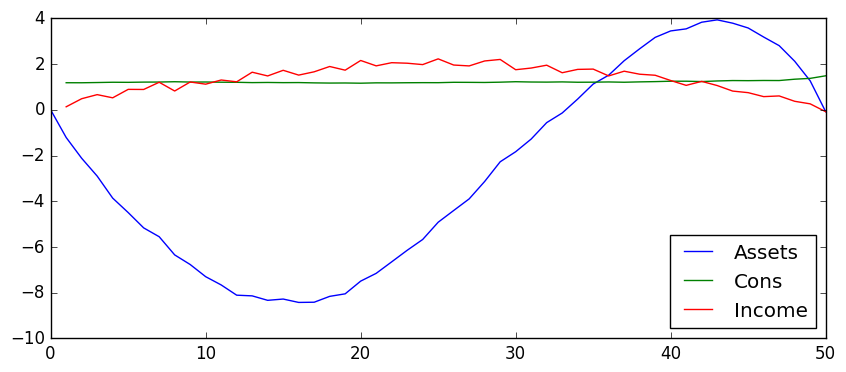

In [27]:
figure(figsize=[10,4])
plot([0; time],assets,label="Assets")
plot(time,cons,label="Cons")
plot(time,income,label="Income")
legend(loc="lower right");

The agent takes out quite a lot of debt in the early age to finance a almost perfectly smoothed consumption path. The minor wiggles come from partially compensating for income shocks. The lion share of debt is payed back in the middle age. Retirement savings peak at about three times the mean consumption.